In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from pathlib import Path
import shutil
import random
from skimage.io import imread
from PIL import Image

# Tensorflow and Keras
import tensorflow as tf
import tensorflow_addons as tfa
  # Image processing
from keras.utils import img_to_array, load_img
from keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomTranslation, RandomRotation, RandomContrast
  # Model
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow_addons.metrics import F1Score
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [10]:
train_dir = Path('images_split/Training')
val_dir = Path('images_split/Validation')
test_dir = Path('images_split/Test')

### Image Generators

In [3]:
img_width, img_height = 224, 224
batch_size = 64

train_generator = image_dataset_from_directory(
    train_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical')

val_generator = image_dataset_from_directory(
    val_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False)

test_generator = image_dataset_from_directory(
    test_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False)

Found 11596 files belonging to 114 classes.
Found 2485 files belonging to 114 classes.
Found 2486 files belonging to 114 classes.


# VGG-19

In [5]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

def create_model(input_shape, n_classes, optimizer='adam', metrics=['accuracy']):
    """
    Compiles a model integrated with VGG-19 pretrained layers and data augmentation
        input_shape: tuple - the shape of input images (width, height, channels)
        n_classes: int - number of classes for the output layer
        optimizer: string (defaults to 'adam')
        optimizer: list (defaults to 'accuracy')
    """
    # Data augmentation layers
    data_augmentation = Sequential([
        Rescaling(1./255),
        RandomFlip("horizontal_and_vertical"),
        RandomContrast(0.3),
        RandomTranslation(0.1, 0.2),
        RandomRotation(0.2)
    ])

    # Input + data augmentation
    input_img = Input(shape=input_shape)
    augmented_img = data_augmentation(input_img)

    # Load the VGG19 model with pre-trained weights, excluding the top (fully connected) layers
    vgg19_base = VGG19(include_top=False, weights='imagenet', input_tensor=augmented_img)
    vgg19_base.trainable = False

    # Adding last layers
    pooled_output = GlobalAveragePooling2D()(vgg19_base.output)
    dense_layer = Dense(256, activation='relu')(pooled_output)
    dropout_layer = Dropout(0.25)(dense_layer)
    dense_layer = Dense(256, activation='relu')(dropout_layer)
    dropout_layer = Dropout(0.25)(dense_layer)
    output_layer = Dense(n_classes, activation='softmax')(dropout_layer)

    # Final model
    model = Model(inputs=input_img, outputs=output_layer)

    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

    return model

In [7]:
opt_adam = Adam(learning_rate=0.001)
f1 = F1Score(num_classes=114, average='weighted')

model = create_model(input_shape=(224, 224, 3),
                     n_classes=114,
                     optimizer=opt_adam,
                     metrics=['accuracy', f1])

In [8]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     1475

In [41]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='vgg19_model_best.weights.hdf5',
                             save_best_only=True,
                             verbose=1,
                             monitor='val_loss',
                             mode='min')


early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [42]:
# Train
history = model.fit(train_generator,
                    epochs=200,
                    validation_data=val_generator,
                    callbacks=[checkpoint, early_stop])

Epoch 1/200
182/182 [==============================] - ETA: 0s - loss: 4.5279 - accuracy: 0.0403 - f1_score: 0.0140
Epoch 1: val_loss improved from inf to 4.40292, saving model to vgg19_model_best.weights.hdf5
182/182 [==============================] - 204s 1s/step - loss: 4.5279 - accuracy: 0.0403 - f1_score: 0.0140 - val_loss: 4.4029 - val_accuracy: 0.0551 - val_f1_score: 0.0187
Epoch 2/200
182/182 [==============================] - ETA: 0s - loss: 4.4019 - accuracy: 0.0516 - f1_score: 0.0208
Epoch 2: val_loss improved from 4.40292 to 4.32575, saving model to vgg19_model_best.weights.hdf5
182/182 [==============================] - 198s 1s/step - loss: 4.4019 - accuracy: 0.0516 - f1_score: 0.0208 - val_loss: 4.3257 - val_accuracy: 0.0584 - val_f1_score: 0.0157
Epoch 3/200
182/182 [==============================] - ETA: 0s - loss: 4.3396 - accuracy: 0.0544 - f1_score: 0.0247
Epoch 3: val_loss improved from 4.32575 to 4.25787, saving model to vgg19_model_best.weights.hdf5
182/182 [=====

In [43]:
# Evaluate
model.load_weights('vgg19_model_best.weights.hdf5')
loss, accuracy, f1 = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test F1 Score:", f1)

39/39 [==============================] - 13s 327ms/step - loss: 3.6470 - accuracy: 0.1698 - f1_score: 0.1417
Test Loss: 3.646986722946167
Test Accuracy: 0.16975060105323792
Test F1 Score: 0.14173731207847595


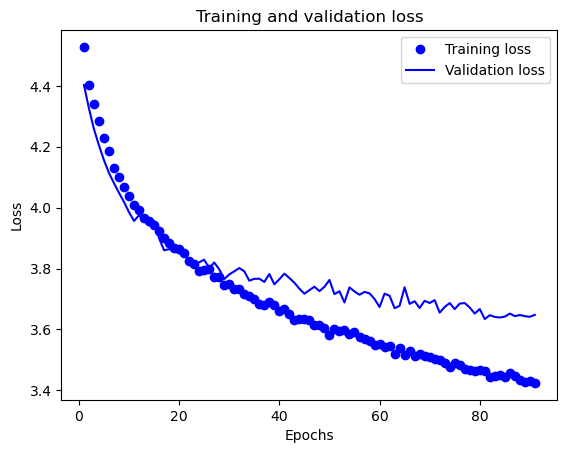

In [44]:
# Loss visualization
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VGG-16

In [49]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

def create_model(input_shape, n_classes, optimizer='adam', metrics=['accuracy']):
    """
    Compiles a model integrated with VGG-16 pretrained layers and data augmentation
        input_shape: tuple - the shape of input images (width, height, channels)
        n_classes: int - number of classes for the output layer
        optimizer: string (defaults to 'adam')
        optimizer: list (defaults to 'accuracy')
    """
    # Data augmentation layers
    data_augmentation = Sequential([
        Rescaling(1./255),
        RandomFlip("horizontal_and_vertical"),
        RandomContrast(0.3),
        RandomTranslation(0.1, 0.2),
        RandomRotation(0.2)
    ])

    # Input + data augmentation
    input_img = Input(shape=input_shape)
    augmented_img = data_augmentation(input_img)

    # Load the VGG19 model with pre-trained weights, excluding the top (fully connected) layers
    vgg16_base = VGG16(include_top=False, weights='imagenet', input_tensor=augmented_img)
    vgg16_base.trainable = False

    # Adding last layers
    pooled_output = GlobalAveragePooling2D()(vgg16_base.output)
    dense_layer = Dense(256, activation='relu')(pooled_output)
    dropout_layer = Dropout(0.25)(dense_layer)
    dense_layer = Dense(256, activation='relu')(dropout_layer)
    dropout_layer = Dropout(0.25)(dense_layer)
    output_layer = Dense(n_classes, activation='softmax')(dropout_layer)

    # Final model
    model = Model(inputs=input_img, outputs=output_layer)

    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

    return model

In [50]:
opt_adam = Adam(learning_rate=0.001)
f1 = F1Score(num_classes=114, average='weighted')

model = create_model(input_shape=(224, 224, 3),
                     n_classes=114,
                     optimizer=opt_adam,
                     metrics=['accuracy', f1])

In [51]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='vgg16_model_best.weights.hdf5',
                             save_best_only=True,
                             verbose=1,
                             monitor='val_loss',
                             mode='min')


early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [52]:
# Train
history = model.fit(train_generator,
                    epochs=200,
                    validation_data=val_generator,
                    callbacks=[checkpoint, early_stop])

Epoch 1/200
182/182 [==============================] - ETA: 0s - loss: 4.5209 - accuracy: 0.0395 - f1_score: 0.0136
Epoch 1: val_loss improved from inf to 4.39717, saving model to vgg16_model_best.weights.hdf5
182/182 [==============================] - 179s 961ms/step - loss: 4.5209 - accuracy: 0.0395 - f1_score: 0.0136 - val_loss: 4.3972 - val_accuracy: 0.0612 - val_f1_score: 0.0211
Epoch 2/200
182/182 [==============================] - ETA: 0s - loss: 4.3733 - accuracy: 0.0537 - f1_score: 0.0265
Epoch 2: val_loss improved from 4.39717 to 4.26857, saving model to vgg16_model_best.weights.hdf5
182/182 [==============================] - 175s 958ms/step - loss: 4.3733 - accuracy: 0.0537 - f1_score: 0.0265 - val_loss: 4.2686 - val_accuracy: 0.0692 - val_f1_score: 0.0271
Epoch 3/200
182/182 [==============================] - ETA: 0s - loss: 4.2651 - accuracy: 0.0671 - f1_score: 0.0375
Epoch 3: val_loss improved from 4.26857 to 4.15799, saving model to vgg16_model_best.weights.hdf5
182/182 

In [54]:
# Evaluate
model.load_weights('vgg16_model_best.weights.hdf5')
loss, accuracy, f1 = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test F1 Score:", f1)

39/39 [==============================] - 7s 170ms/step - loss: 3.5157 - accuracy: 0.2015 - f1_score: 0.1696
Test Loss: 3.5157012939453125
Test Accuracy: 0.20152856409549713
Test F1 Score: 0.1696225255727768


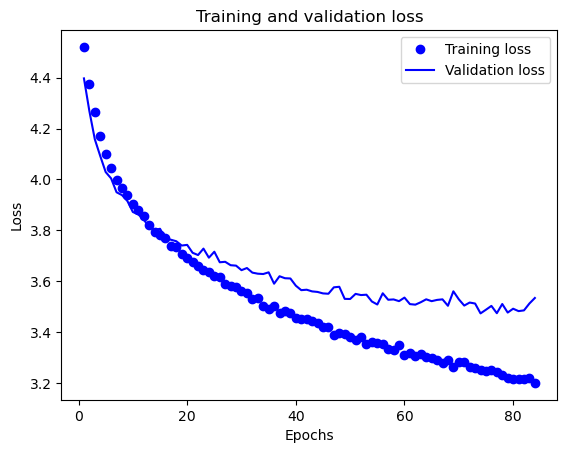

In [55]:
# Loss visualization
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()